<a href="https://colab.research.google.com/github/Rafsun-Islam/CSE366/blob/main/Lab02/smartphone_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import random
import matplotlib.pyplot as plt

In [12]:
# Base classes for environment and agent
class Displayable(object):
    """
    Base class for enabling debug-level printing.
    """
    max_display_level = 1  # Default debug level

    def display(self, level, *args, **kwargs):
        """
        Print messages only if the debug level is sufficient.
        Args:
            level (int): The debug level of the message.
        """
        if level <= self.max_display_level:
            print(*args, **kwargs)


class Environment(Displayable):
    """
    Abstract base class for all environments.
    Provides methods for defining the initial state and performing actions.
    """
    def initial_percept(self):
        """
        Define the initial state of the environment.
        Must be overridden in derived classes.
        """
        raise NotImplementedError("initial_percept must be implemented.")

    def do(self, action):
        """
        Update the environment state based on the given action.
        Must be overridden in derived classes.
        """
        raise NotImplementedError("do must be implemented.")


class Agent(Displayable):
    """
    Abstract base class for all agents.
    Provides methods for selecting and performing actions.
    """
    def initial_action(self, percept):
        """
        Get the initial action for the agent.
        By default, calls select_action with the percept.
        """
        return self.select_action(percept)

    def select_action(self, percept):
        """
        Decide the action based on the given percept.
        Must be overridden in derived classes.
        """
        raise NotImplementedError("select_action must be implemented.")


class Simulate(Displayable):
    """
    Manages the interaction between an agent and its environment.
    Simulates the environment-agent loop for a fixed number of steps.
    """
    def __init__(self, agent, environment):
        """
        Initialize the simulation with an agent and an environment.
        Args:
            agent (Agent): The agent making decisions.
            environment (Environment): The environment to interact with.
        """
        self.agent = agent
        self.env = environment
        self.percept = self.env.initial_percept()  # Initial state
        self.percept_history = [self.percept]  # Track percepts over time
        self.action_history = []  # Track actions taken

    def go(self, n):
        """
        Run the simulation for n time steps.
        Args:
            n (int): Number of time steps to simulate.
        """
        for i in range(n):
            print(f"Step {i + 1}:")
            print(f"    Current Percept: {self.percept}")
            # Agent decides an action based on the current percept
            action = self.agent.select_action(self.percept)
            print(f"    Action Taken: {action}")
            self.action_history.append(action)
            # Environment updates based on the action
            self.percept = self.env.do(action)
            self.percept_history.append(self.percept)
            print(f"    Updated Percept: {self.percept}\n")



In [13]:
class SmartphoneAgent(Agent):
    """
    An agent for managing smartphone inventory.
    The agent decides how many units to order based on price and stock level.
    """
    def __init__(self, environment):
        """
        Initialize the agent using the environment's initial percepts.
        Args:
            environment (Environment): The environment to interact with.
        """
        percept = environment.initial_percept()
        self.ave = percept['price']  # Average price of the smartphone
        self.last_price = percept['price']  # Last observed price
        self.instock = percept['instock']  # Current stock level
        self.buy_history = []  # List of units bought at each step

    def select_action(self, percept):
        """
        Decide the number of units to order based on the given percept.
        Args:
            percept (dict): The current price and stock level.
        Returns:
            dict: The action to perform, e.g., {'buy': number_of_units}.
        """
        # Update the agent's state based on the percept
        self.last_price = percept['price']
        self.ave = self.ave + (self.last_price - self.ave) * 0.05  # Smooth average
        self.instock = percept['instock']

        # Decision rules for ordering
        if self.last_price < 0.8 * self.ave:  # Significant price drop (20% below average)
            if self.instock >= 10:  # Stock is not critically low
                tobuy = 15
            else:
                tobuy = 0  # Avoid overstocking when stock is critically low
        elif self.instock < 10:  # Stock is critically low
            tobuy = 10
        else:  # Default case: no action
            tobuy = 0

        self.buy_history.append(tobuy)  # Track the decision
        return {'buy': tobuy}


In [14]:
class SmartphoneEnv(Environment):
    """
    Environment for simulating the smartphone inventory and price changes.
    """
    def __init__(self):
        """
        Initialize the environment with initial stock and price values.
        """
        self.time = 0  # Time step counter
        self.stock = 20  # Starting stock level
        self.stock_history = []  # Record of stock levels
        self.price_history = []  # Record of price changes

    def initial_percept(self):
        """
        Provide the initial state of the environment.
        Returns:
            dict: The initial price and stock level.
        """
        initial_price = 600  # Starting price of the smartphone
        self.stock_history.append(self.stock)
        self.price_history.append(initial_price)
        return {'price': initial_price, 'instock': self.stock}

    def do(self, action):
        """
        Update the environment's state based on the agent's action.
        Args:
            action (dict): The agent's action, e.g., {'buy': number_of_units}.
        Returns:
            dict: The updated price and stock level.
        """
        # Apply the agent's action
        bought = action['buy']
        # Simulate random consumption of stock
        used = random.choice([1, 2, 3])
        self.stock = self.stock + bought - used
        self.stock_history.append(self.stock)

        # Simulate price fluctuations using Gaussian distribution
        mean_change = 0  # Mean price change
        stddev = 50  # Standard deviation for price changes
        new_price = self.price_history[-1] + random.gauss(mean_change, stddev)
        self.price_history.append(max(int(new_price), 1))  # Ensure price doesn't drop below 1

        return {'price': self.price_history[-1], 'instock': self.stock}


Step 1:
    Current Percept: {'price': 600, 'instock': 20}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 556, 'instock': 18}

Step 2:
    Current Percept: {'price': 556, 'instock': 18}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 590, 'instock': 16}

Step 3:
    Current Percept: {'price': 590, 'instock': 16}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 548, 'instock': 15}

Step 4:
    Current Percept: {'price': 548, 'instock': 15}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 563, 'instock': 13}

Step 5:
    Current Percept: {'price': 563, 'instock': 13}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 559, 'instock': 11}

Step 6:
    Current Percept: {'price': 559, 'instock': 11}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 535, 'instock': 10}

Step 7:
    Current Percept: {'price': 535, 'instock': 10}
    Action Taken: {'buy': 0}
    Updated Percept: {'price': 593, 'instock': 7}

Step 8:
    Current P

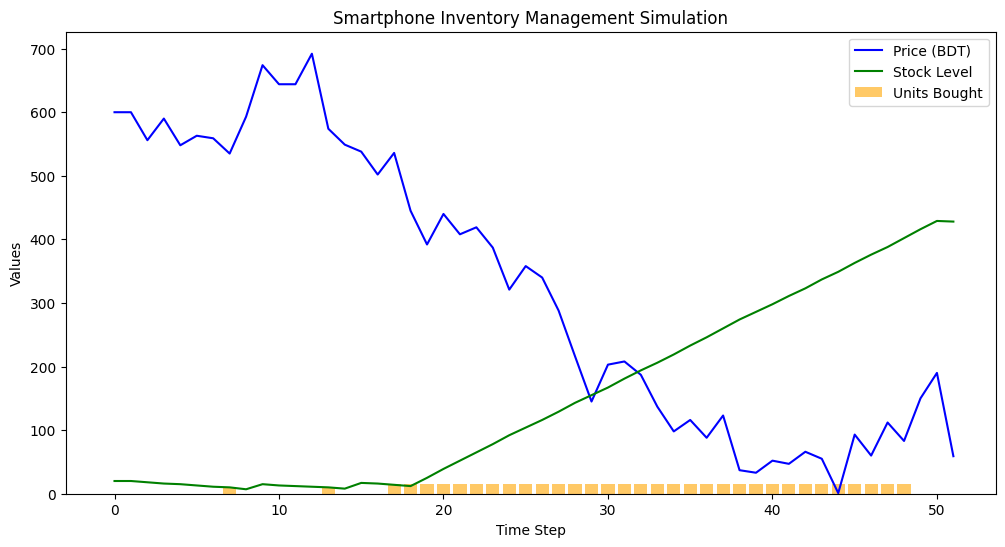

In [15]:
# Simulation setup
env = SmartphoneEnv()  # Initialize the environment
agent = SmartphoneAgent(env)  # Initialize the agent
simulation = Simulate(agent, env)  # Create the simulation

# Run the simulation for 50 time steps
simulation.go(50)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(env.price_history, label="Price (BDT)", color="blue")
plt.plot(env.stock_history, label="Stock Level", color="green")
plt.bar(range(len(agent.buy_history)), agent.buy_history, label="Units Bought", color="orange", alpha=0.6)
plt.xlabel("Time Step")
plt.ylabel("Values")
plt.title("Smartphone Inventory Management Simulation")
plt.legend()
plt.show()
